# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

20 Dangerous curve to the right


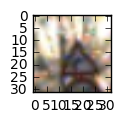

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
from sklearn.utils import shuffle

%matplotlib inline
index = random.randint(0, len(X_train)) 
image = X_train[index].squeeze()

#  Get the text labels associated with numbered labels
data_pd = pd.read_csv('signnames.csv')

# Plot a random image and its label
plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index], data_pd['SignName'][y_train[index]])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

def img_pre_process(imgx):
    
    # Remove the effect of brightness
    imgx[:,:,0] = cv2.equalizeHist(imgx[:,:,0])
    imgx[:,:,1] = cv2.equalizeHist(imgx[:,:,1])
    imgx[:,:,2] = cv2.equalizeHist(imgx[:,:,1])

    #Normalize image as per-lecture notes
    imgx = imgx.astype(float)
    a = -0.5
    b = 0.5
    grayscale_min = 0
    grayscale_max = 255
    imgx =  a + ( ( (imgx - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )
    return imgx

def transform_image(image, ang_range, shear_range, trans_range):

    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols, ch = image.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2), ang_rot, 1)

    # Translation
    tr_x = trans_range*np.random.uniform() - trans_range/2
    tr_y = trans_range*np.random.uniform() - trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5 + shear_range*np.random.uniform() - shear_range/2
    pt2 = 20 + shear_range*np.random.uniform()- shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    image = cv2.warpAffine(image,Rot_M,(cols,rows))
    image = cv2.warpAffine(image,Trans_M,(cols,rows))
    image = cv2.warpAffine(image,shear_M,(cols,rows))
    
    image = img_pre_process(image)
    return image

# Generate additional training data by transforming multiple copies of the original image
# Retain the original image also
def generate_additional_data(X, y, num_transforms, ang_range, shear_range, trans_range):  
    X_array = []
    y_array = []
    xlen = len(X)
    for i in range(xlen):
        X_array.append(X[i])
        y_array.append(y[i])
        for j in range(num_transforms):
            img_transform = transform_image(X[i], ang_range, shear_range, trans_range)
            X_array.append(img_transform)
            y_array.append(y[i])

    X_array = np.array(X_array, dtype = np.float32())
    y_array = np.array(y_array, dtype = np.float32())
  
    # Shuffle the data
    idx_array = np.arange(len(y_array))
    np.random.shuffle(idx_array)
    X_array[idx_array] = X_array
    y_array[idx_array] = y_array

    return X_array, y_array

# Pre-process multiple images
def img_batch_pre_process(batch_set_x):
    return np.array([img_pre_process(batch_set_x[i]) for i in range(len(batch_set_x))],
                          dtype = np.float32)

ang_rng = 10
shear_rng = 2.0
trans_rng = 2.0

# Generate the additional images with the above parameter ranges for rotation, shear and translation. Generate 5 
# transforms of this image
X_train, y_train = generate_additional_data(X_train, y_train, 5, ang_rng, shear_rng, trans_rng)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**   

For pre-processing as per the recommendation from my mentor, I checked out the blog-post by Udacity student Vivek Yadav who got test-accuracy of 98.8%.  In his posting at 
https://chatbotslife.com/german-sign-classification-using-deep-learning-neural-networks-98-8-solution-d05656bf51ad#.up65phpnb he recommended the pre-processing steps of brightness normalization to take away the effects of brightness variations.This I did by applying histogram equalization [https://en.wikipedia.org/wiki/Histogram_equalization] from the OpenCV library. I followed that up normalizing the data so their intensity values vary between -.5 and .5.

The paper by Yann LeCun and Pierre Sermanet [Traffic Sign Recognition with Multi-Scale Convolutional Networks] discussed augmenting the original data set by adding 5 additional images each by randomly perturbing the original images by modifiying their rotation and blur. Yadav in his blog post also discussed the augmenting of original images  with affine transformations of rotation, shear and translation. He provided code provided in [https://github.com/vxy10/ImageAugmentation] for this image augmentation which I leveraged.

As per the instructions above, I shuffled the data randomly.

In [5]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

n_train = len(X_train)
n_validation = len(X_validation)

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)





Number of training examples = 188203
Number of validation examples = 47051


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
1. I split the training data set into a training and validation set as shown in previous code cell. I will use the validation set to evaluate my model amd hyper-parameter choices. I used train_test_split and kept aside 20% for the validation set.

I did generate additional data as per my discussion above by applying image jittering.

In [6]:


EPOCHS = 20
BATCH_SIZE = 256


### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten

layer_depth = {
    'layer_0': 3,
    'layer_1': 32,
    'layer_2': 64,
    'fully_connected_3': 1024,
    'fully_connected_4': 1024,
    'fully_connected_5': n_classes,
}

mu = 0
sigma = 0.05

weights = {
    'layer_0': tf.Variable(tf.truncated_normal(
        [1, 1, 3, layer_depth['layer_0']], mean = mu, stddev = sigma)),
    'layer_1': tf.Variable(tf.truncated_normal(
        [5, 5, 3, layer_depth['layer_1']], mean = mu, stddev = sigma)),
    'layer_2': tf.Variable(tf.truncated_normal(
        [5, 5, layer_depth['layer_1'], layer_depth['layer_2']], mean = mu, stddev = sigma)),
    'fully_connected_3': tf.Variable(tf.truncated_normal(
        [4096, layer_depth['fully_connected_3']], mean = mu, stddev = sigma)),
    'fully_connected_4': tf.Variable(tf.truncated_normal(
        [1024, layer_depth['fully_connected_4']], mean = mu, stddev = sigma)),
    'fully_connected_5': tf.Variable(tf.truncated_normal(
        [1024, layer_depth['fully_connected_5']], mean = mu, stddev = sigma)),
}

biases = {
    'layer_0': tf.Variable(tf.zeros(layer_depth['layer_0'])),
    'layer_1': tf.Variable(tf.zeros(layer_depth['layer_1'])),
    'layer_2': tf.Variable(tf.zeros(layer_depth['layer_2'])),
    'fully_connected_3': tf.Variable(tf.zeros(layer_depth['fully_connected_3'])),
    'fully_connected_4': tf.Variable(tf.zeros(layer_depth['fully_connected_4'])),
    'fully_connected_5': tf.Variable(tf.zeros(layer_depth['fully_connected_5'])),
}



def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x), W

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')



def LeNet(x, keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.05
    
     # Layer 0: Convolutional. Input = 32x32x3. Output = 32x32x3.
    conv0, wt0 = conv2d(x, weights['layer_0'], biases['layer_0'])
    #print(conv0.get_shape())
    
    # Layer 1: Convolutional. 
    # ReLuActivation.
    # Pooling. Input = 32x32x3. Output = 16x16x32.
    conv1, wt1 = conv2d(conv0, weights['layer_1'], biases['layer_1'])
    conv1 = maxpool2d(conv1)
    #print(conv1.get_shape())


    # Layer 2: Convolutional.
    # Activation.
    # Pooling. Input = 16x16x32. Output = 8x8x64.
    conv2, wt2 = conv2d(conv1, weights['layer_2'], biases['layer_2'])
    conv2 = maxpool2d(conv2)
    #print(conv2.get_shape())


    # Flatten. Input = 8x8x64. Output = 4096.
    fc1= tf.contrib.layers.flatten(conv2)
    #print(fc1.get_shape())

    # Layer 3: Fully Connected. Input = 4096. Output = 1024.
    # Activation
    fc1 = tf.add(tf.matmul(fc1, weights['fully_connected_3']), biases['fully_connected_3'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    wt3 = weights['fully_connected_3']

    # Layer 4: Fully Connected. Input = 1024. Output = 1024
    # Activation.
    fc2 = tf.add(tf.matmul(fc1, weights['fully_connected_4']), biases['fully_connected_4'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)
    wt4 = weights['fully_connected_4']

    # Layer 5: Fully Connected. Input = 1024. Output = n_classes (43)
    logits = tf.add(tf.matmul(fc2, weights['fully_connected_5']), biases['fully_connected_5'])
    wt5 = weights['fully_connected_5']
    
    regularizer_tot = (tf.nn.l2_loss(wt0)  + tf.nn.l2_loss(wt1) + tf.nn.l2_loss(wt2) 
                + tf.nn.l2_loss(wt3) + tf.nn.l2_loss(wt4) + tf.nn.l2_loss(wt5))
    
    return logits, regularizer_tot



### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

*First Attempt*

I started with the LeNet Convolutional Network as my starting point. I had two convolutional network layers each with RELU activation to introduce non-linearity along with max-pooling of stride 2. Both the convolutional networks used 5x5 filters. The first convolutional network took as its input 32x32x3 and output of 28x28x6 after 2d convolution and after max-pooling resulted in output of 14x14x6. Similarly the second convolutional network took the output of the first convolutional network and after RELU and Maxpooling again produced an output of 5x5x16.

After flattening the filtered outputs (5x5x16 to 400) from the convolutional network, I had employed three fully connected layers. In between layer 4 and layer 5 of the fully connected network, I employed dropout to provide regularization, and build in feature redundancy to be able to detect objects. I used keep_prob of 0.5 in this dropout layer while training. While validation and test, the keep_prob is again reset to 1.0.

The weights in both the convolutional network and the fully connected layer were randomized with mean 0 and sigma as 0.05. The biases were initialized to 0.

*Revised Model*

My initial model was based on the initial LeNet model. I studied multiple papers including the blog-post by Yadav [Model section in https://chatbotslife.com/german-sign-classification-using-deep-learning-neural-networks-98-8-solution-d05656bf51ad#.up65phpnb] and felt my test accuracy could be improved further. I could potentially learn more features if I increased the number of filters from 6, 16 to 32, 64 respectively in my two convolutional layers. Yadav also recommened adding an input processing layer0 to select the best color map. Now the paper by Cunn and Sermanet recommend changing the color-space from RGB to YUV and stating that no-color/Y performs better than color but I went with letting the network pick the color-space for layer0.

For layer1 and layer2 - my convolutional layers, I increased the number of filters to 32 and 64 from the simple LeNet model in the hope that I would learn more features. I retained maxpooling to downsample the images and still used ReLu activation to introduce non-linearity after my convolutional layers.

Net net when I got to the flattening process and the fully-connected layer, I ended up with 4096 inputs which I reduced to 1024 outputs. 

*Overfitting Avoidance in the Revised Model*

To avoid overfitting I employed dropout after each of the fully connected layers. I also applied l2-regularization as per the guidance in the forums to avoid large weights in the model and reduce variance in our model and improve our test accuracy.



In [7]:
### Train your model here.
### Feel free to use as many code cells as needed.

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

keep_prob = tf.placeholder(tf.float32)
rate = 0.001
lamb = 1e-5

logits, regularizer_cost = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)+(lamb*regularizer_cost)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        #batch_x = img_batch_pre_process(batch_x)
        # Keep_prob is set to 1 because we are evaluating the model
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")
    



Training...

EPOCH 1 ...
Validation Accuracy = 0.958

EPOCH 2 ...
Validation Accuracy = 0.988

EPOCH 3 ...
Validation Accuracy = 0.995

EPOCH 4 ...
Validation Accuracy = 0.996

EPOCH 5 ...
Validation Accuracy = 0.995

EPOCH 6 ...
Validation Accuracy = 0.997

EPOCH 7 ...
Validation Accuracy = 0.997

EPOCH 8 ...
Validation Accuracy = 0.998

EPOCH 9 ...
Validation Accuracy = 0.997

EPOCH 10 ...
Validation Accuracy = 0.998

EPOCH 11 ...
Validation Accuracy = 0.997

EPOCH 12 ...
Validation Accuracy = 0.997

EPOCH 13 ...
Validation Accuracy = 0.998

EPOCH 14 ...
Validation Accuracy = 0.998

EPOCH 15 ...
Validation Accuracy = 0.998

EPOCH 16 ...
Validation Accuracy = 0.997

EPOCH 17 ...
Validation Accuracy = 0.998

EPOCH 18 ...
Validation Accuracy = 0.998

EPOCH 19 ...
Validation Accuracy = 0.998

EPOCH 20 ...
Validation Accuracy = 0.998

Model saved


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** 

I have described my Network model above. In terms of Hyper-paramaters of the essentially LeNet model with Maxpooling, I used the following :
1. Number of Epochs 20
2. Batch Size 256
3. Learning Rate 0.01 used with Adam Optimizer
4. Keep_prob of 0.5 in fully-connected layer 
5. lamda - l2-regularization constant I used 1e-5

As per the class notes AdamOptimizer was leveraged for the optimization process. In coming up with the above hyper-parameters, I essentially used an empirical approach trying to see which ones showed satisfactory performance with the Validation Set.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:** 

Please see my answer to Question 3 which discusses my approach to coming up with an approach for the solution to the problem. I was able to improve my validation accuracy from 97% to 99.7% [see above] and my test accuracy from 93% to 95.5% [see below].


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Test Accuracy = 0.955


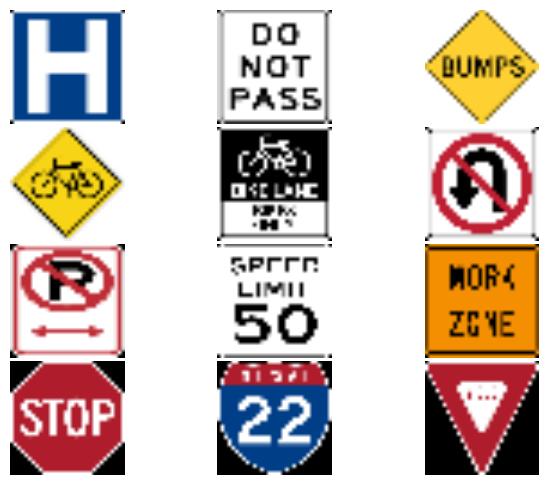

In [8]:
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    X_test = img_batch_pre_process(X_test)
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    
    
### Load the images and plot them here.
def process_image_file(name):
    image = cv2.imread(name)
    image = cv2.resize(image,(32, 32))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype(float)
    a = -0.5
    b = 0.5
    grayscale_min = 0
    grayscale_max = 255
    image =  a + ( ( (image - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )
    return image

def plot_downloaded_images(rows, columns, images):

    plt.figure(figsize = (8, 6))
    gs1 = gridspec.GridSpec(rows, columns)
    gs1.update(wspace=0.01, hspace=0.03) # set the spacing between axes. 
    
    num_images = rows*columns
    for i in range(num_images):
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        plt.imshow(images[i])
        plt.axis('off')
        
    plt.show()


# Get the test data for images downloaded and then plot them
testdata = [process_image_file("./downloaded-images/"+ f) for f in os.listdir("./downloaded-images/")]
labeltestdata = [f for f in os.listdir("./downloaded-images/")]
testdata = np.array(testdata, dtype = np.float32)

plot_downloaded_images(4, 3, testdata + 0.5)


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:** I chose 12 images from the web. These are US Signs so there are some that are not trained as part of German training set.

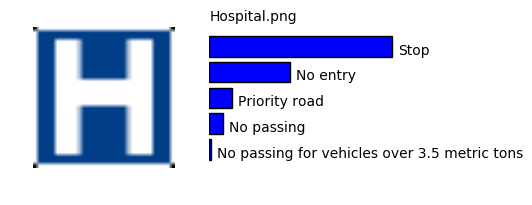

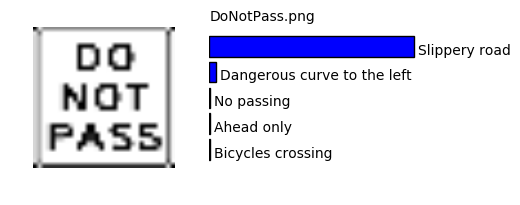

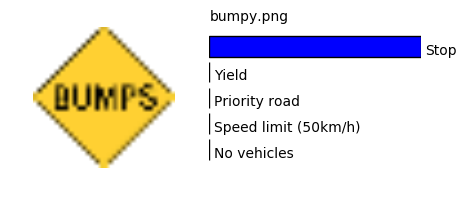

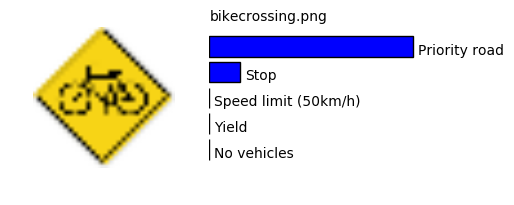

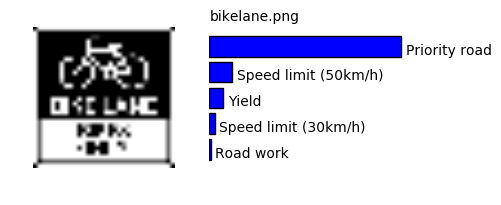

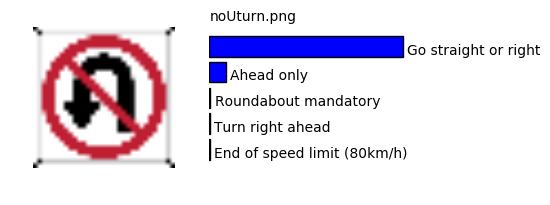

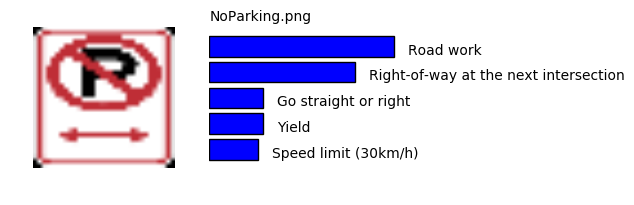

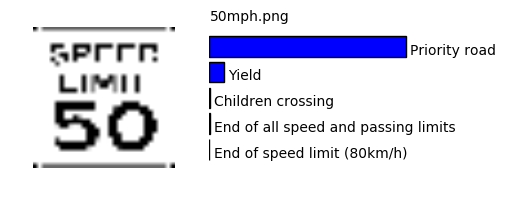

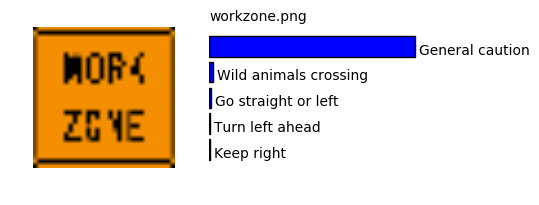

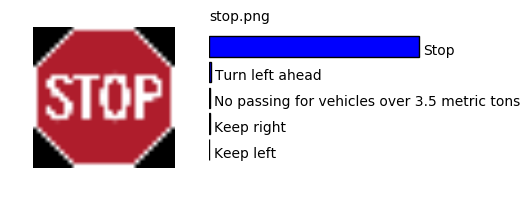

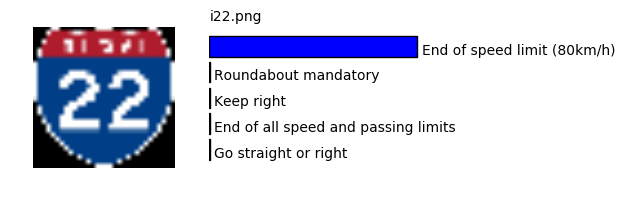

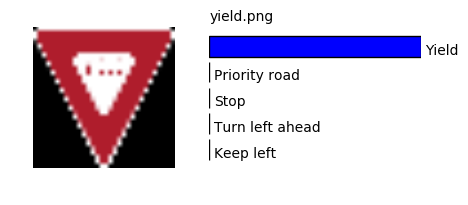

In [9]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
# Visualizations will be shown in the notebook.
labels_predictions = tf.nn.softmax(logits)
top5 = tf.nn.top_k(labels_predictions, 5)
feed_dict_test = {x:testdata, keep_prob: 1}

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions = sess.run(labels_predictions,feed_dict = feed_dict_test)
    top5_predictions = sess.run([labels_predictions, top5], feed_dict=feed_dict_test)

    for i in range(12):
        plt.figure(figsize = (5, 2))
        gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3])
        
        # Display the image
        plt.subplot(gs[0])
        plt.imshow(testdata[i] + .5)
        plt.axis('off')
        
        # Do a horizontal bar-plot of the probabilities
        plt.subplot(gs[1])
        bottom = 6 - np.arange(5)
        width = top5_predictions[1][0][i]
        plt.barh(bottom, width, align='center')
        for i_label in range(5):
            labellocationx = top5_predictions[1][0][i][i_label] + .02
            labellocationy = 6 - i_label -.3
            stringname = data_pd['SignName'][top5_predictions[1][1][i][i_label]]
            plt.text(labellocationx, labellocationy, stringname)
    
        plt.axis('off')
        plt.text(0, 7, labeltestdata[i])
        plt.show()


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:** 
Please refer to the above code-box for visualization of the top5 predicted softmax categories along with the actual US images. While US matching signs like Yield and STOP are recognized properly by my model, the others are not captured by the German set. I get a test accuracy of 16.7% (2/12) with the above implementation.

In [10]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**Please refer to the above code-box for visualization of the top5 predicted softmax categories along with the actual US image. The correct predictions work only for the US images.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.